# MPC for pendulum
model predictive control for simple pendulum        
inspired by:        
https://github.com/simorxb/MPC-Pendulum-Python-2/blob/main/MPC.py

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML, SVG, display
import pydot
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    LeafSystem,
    Linearize,
    RigidTransform,
    RotationMatrix,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    Parser,
    Simulator,
    StartMeshcat,
    DirectCollocation,
    FiniteHorizonLinearQuadraticRegulator,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    LogVectorOutput,
    MakeFiniteHorizonLinearQuadraticRegulator,
    MultibodyPlant,
    MultibodyPositionToGeometryPose,
    PiecewisePolynomial,
    PlanarSceneGraphVisualizer,
    SceneGraph,
    SnoptSolver,
    Solve,
    TrajectorySource,
    MathematicalProgram,
    MakeVectorVariable,
    Variable,
    ConstantVectorSource,
    SnoptSolver,
    SolverOptions,
    SolverType,
    PassThrough
)

from pydrake.examples import AcrobotGeometry, AcrobotPlant, PendulumPlant, PendulumState, PendulumGeometry
from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from IPython.core.display import Image, display
from underactuated.pendulum import PendulumVisualizer

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


diagram systems:


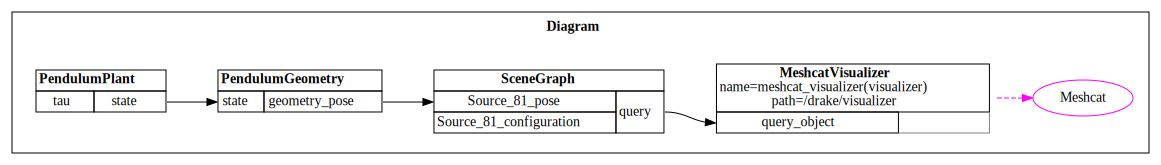

::_ Context (of a Diagram)
---------------------------
2 total continuous states
4 total numeric parameters in 1 groups
2 total abstract parameters

::_::drake/examples/pendulum/PendulumPlant@000061369518a650 Context
--------------------------------------------------------------------
Time: 0
States:
  2 continuous states
    0.5   0

Parameters:
  1 numeric parameter groups with
     4 parameters
          1  0.5  0.1 9.81

::_::drake/geometry/SceneGraph@00006136951605c0 Context
--------------------------------------------------------
Time: 0
Parameters:
  2 abstract parameters

[Variable('x(0)', Continuous) Variable('x(1)', Continuous)]
[0. 0.]
optimiztion success:  True
optimal cost: 91.19151728516151
(21,)
tau 0.18172569431761135
::_ Context (of a Diagram)
---------------------------
2 total continuous states
4 total numeric parameters in 1 groups
2 total abstract parameters

::_::drake/examples/pendulum/PendulumPlant@000061369518a650 Context
---------------------------------------

In [5]:
def pend_dircol(N):
    plant = PendulumPlant()
    context = plant.CreateDefaultContext()

    max_dt = 0.5
    N * max_dt
    dircol = DirectCollocation(
        plant, # we do not have to explicitly set the dynamics as constraints. It does it by itself here
        context,
        num_time_samples=N,
        minimum_time_step=0.05,
        maximum_time_step=max_dt,
    )
    prog = dircol.prog()

    dircol.AddEqualTimeIntervalsConstraints()

    torque_limit = 3.0  # N*m.
    u = dircol.input()
    dircol.AddConstraintToAllKnotPoints(-torque_limit <= u[0])
    dircol.AddConstraintToAllKnotPoints(u[0] <= torque_limit)

    initial_state = PendulumState()
    print(dircol.initial_state())
    print(initial_state.get_value())
    initial_state.set_theta(0.0)
    initial_state.set_thetadot(0.0)
    prog.AddBoundingBoxConstraint(
        initial_state.get_value(),
        initial_state.get_value(),
        dircol.initial_state(),
    )

    final_state = PendulumState()
    final_state.set_theta(np.pi)
    final_state.set_thetadot(0.0)
    prog.AddBoundingBoxConstraint(
        final_state.get_value(), final_state.get_value(), dircol.final_state()
    )
    # dircol.AddLinearConstraint(dircol.final_state() == final_state.get_value())

    R = 10  # Cost on input "effort".
    dircol.AddRunningCost(R * u[0] ** 2)

    initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
        [0.0, 4.0], [initial_state.get_value(), final_state.get_value()]
    )
    dircol.SetInitialTrajectory(PiecewisePolynomial(), initial_x_trajectory)

    result = Solve(prog)
    print('optimiztion success: ', result.is_success() )
    print('optimal cost:', result.get_optimal_cost())
    # return input values
    out = dircol.GetInputSamples(result)
    return out[0]
    
    x_trajectory = dircol.ReconstructStateTrajectory(result)
    print(dircol.GetSampleTimes(result))
    fig, ax = plt.subplots()

    x_knots = np.hstack(
        [
            x_trajectory.value(t)
            for t in np.linspace(
                x_trajectory.start_time(), x_trajectory.end_time(), 100
            )
        ]
    )

    ax.set_xlabel("$q$")
    ax.set_ylabel("$\dot{q}$")
    ax.plot(x_knots[0, :], x_knots[1, :])
    display(plt.show())

    # Animate the result.
    vis = PendulumVisualizer(show=False)
    ani = vis.animate(x_trajectory)
    display(HTML(ani.to_jshtml()))
    


builder = DiagramBuilder()
pendulum = builder.AddSystem(PendulumPlant())

# Setup visualization
scene_graph = builder.AddSystem(SceneGraph())
PendulumGeometry.AddToBuilder(
    builder, pendulum.get_state_output_port(), scene_graph
)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
meshcat.Delete()
meshcat.Set2dRenderMode(
    X_WC=RigidTransform(RotationMatrix.MakeZRotation(np.pi), [0, 1, 0])
)

diagram = builder.Build()
print('diagram systems:')
display(
    SVG(
            pydot.graph_from_dot_data(diagram.GetGraphvizString ())[0].create_svg()
        )
)

simulator = Simulator(diagram)
context = simulator.get_mutable_context() # diagram context

meshcat.AddButton("Stop Simulation")

context.SetContinuousState([0.5, 0])

pendulum_context = pendulum.GetMyMutableContextFromRoot(context)
print(context)


N = 21 # model predictive horizon
time_range = 10.0
dt = 0.1
L = round(time_range/dt)
tau = np.zeros(L)
q_ref = np.zeros(L)
step = 0
for i in range(L):

    # ---- generate reference point. 
    if step < 5:
        q_ref[i] = np.pi
    else:
        q_ref[i] = np.pi / 2

    step += dt

    # ----- solve trajopt for next N steps
    tau_traj = pend_dircol(N)
    print(tau_traj.shape)
    # get the first element
    tau[i] = tau_traj[0]
    print('tau', tau[i])

    # initial solution for the next step
    tau_init = tau_traj

    # ----- run simulation. 
    # extract the state of the next step
    pendulum.GetInputPort("tau").FixValue(pendulum_context, tau[i])
    simulator.AdvanceTo(dt)
    print(context)
    # extract new state
    print(pendulum_context.get_state().get_continuous_state().get_vector() )

    break
